# Embedding

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
from utils.utils import CustomDataset
from torchvision import transforms
from torch.utils.data import  DataLoader
from models.AE_model import Autoencoder
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation


np.random.seed(42)
tf.random.set_seed(42)

In [42]:
# Definir o caminho para o diretório contendo as imagens de treino e teste
data_dir = 'dataset/Kather_texture_2016_image_tiles_5000'
samples, labels = list(), list()

for nome_pasta in os.listdir(data_dir):
    for nome_arquivo in os.listdir(os.path.join(data_dir, nome_pasta)):
        samples.append(os.path.join(data_dir + '/' + nome_pasta,nome_arquivo))
        labels.append(int(nome_pasta[:2]))

all_data = pd.DataFrame({'path':samples,'label':labels})
all_data['label'] = all_data['label'].astype('str')

In [43]:
all_data.head()

,path,label
0,dataset/Kather_texture_2016_image_tiles_5000/0...,7
1,dataset/Kather_texture_2016_image_tiles_5000/0...,7
2,dataset/Kather_texture_2016_image_tiles_5000/0...,7
3,dataset/Kather_texture_2016_image_tiles_5000/0...,7
4,dataset/Kather_texture_2016_image_tiles_5000/0...,7


In [44]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
dataset = CustomDataset(dataframe=all_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [45]:
model = Autoencoder()

In [46]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [59]:
# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    # if epoch % 5== 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 0.0056
Epoch [2/20], Loss: 0.0114
Epoch [3/20], Loss: 0.0067
Epoch [4/20], Loss: 0.0078
Epoch [5/20], Loss: 0.0077
Epoch [6/20], Loss: 0.0061
Epoch [7/20], Loss: 0.0066
Epoch [8/20], Loss: 0.0062
Epoch [9/20], Loss: 0.0064
Epoch [10/20], Loss: 0.0081
Epoch [11/20], Loss: 0.0060
Epoch [12/20], Loss: 0.0083
Epoch [13/20], Loss: 0.0089
Epoch [14/20], Loss: 0.0059
Epoch [15/20], Loss: 0.0062
Epoch [16/20], Loss: 0.0059
Epoch [17/20], Loss: 0.0065
Epoch [18/20], Loss: 0.0065
Epoch [19/20], Loss: 0.0045
Epoch [20/20], Loss: 0.0061


<Figure size 1600x1200 with 0 Axes>

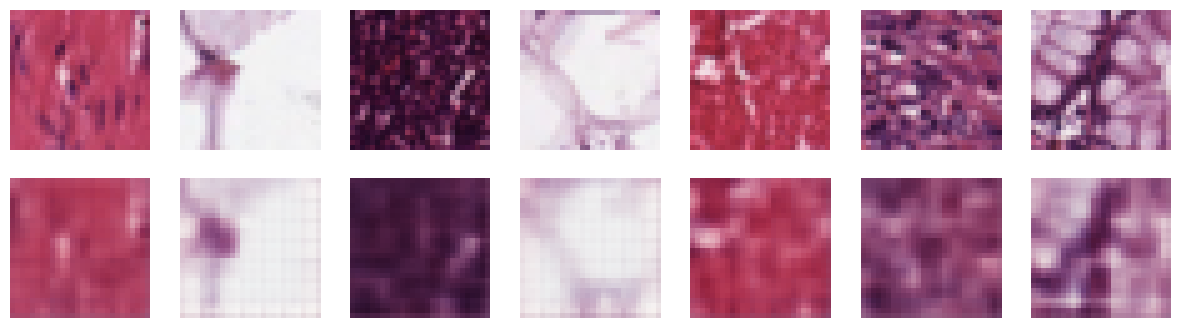

In [60]:
with torch.no_grad():
    for data in dataloader:
        recon = model(data)
        break
         
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

In [61]:
embed_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

In [106]:
for image in embed_dataloader:
    X = model.encoder(image)
y = torch.tensor(all_data.label.astype(int))

In [63]:
X.shape

torch.Size([5000, 392])

## Seleção de parcela dos dados para aprendizado Semi-Supervisionado

In [ ]:
training_indices = random.sample(list(range(X.shape[0])), int(0.1 * X.shape[0]))
training_mask = np.full(X.shape[0], -1)

for i in training_indices:
    training_mask[i] = y[i]

## Aplicar o KMeans sem rótulos para fazer a divisão dos grafos para o LabelPropagation + validação

In [64]:
modelo_kmeans = KMeans(n_clusters=8)
grupos = modelo_kmeans.fit_predict(X.detach().numpy())

In [65]:
# Distribuição do kmeans
torch.bincount(torch.tensor(grupos))

tensor([ 225,  775,  852,  447,  366,  704, 1119,  512])

In [88]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X.detach().numpy(), training_mask)
predict_lp = label_prop_model.predict(X.detach().numpy())

FloatingPointError: underflow encountered in exp

## SVC + Self Training + validação

In [111]:
import numpy as np
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(X.detach().numpy(), training_mask)

SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True))

In [115]:
y_pred = self_training_model.predict(X.detach().numpy())

In [118]:
from sklearn.metrics import accuracy_score, f1_score

print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred, average='weighted'))

0.6746
0.670447546683935


In [119]:
print(accuracy_score(y, grupos))

0.032


## GNN + validação

dados iniciais em imagem -> treinar um modelo para embedding (CNN_AE) -> 3 algoritmos de classificicação semi-supervisionado (SVC + SelfTraining), Label Propagation, GNN, método noia
